# Funderstanding competitive neural networks

[Chris von Csefalvay](mailto:csefalvayk@starschema.net) | [Starschema](https://starschema.net) | 27JAN2019

_This is the companion notebook to the article_ [Funderstanding competitive neural networks](https://medium.com/starschema-blog/funderstanding-competitive-neural-networks-f4dae1cb3c1f). _You will find a slightly more in-depth and code-driven look at the issues here than in the original article. I recommend you read the article first, then move on to the notebook._

This is the first in a series of notebooks that demonstrates competitive neural networks, a form of **unsupervised learning in neural networks**. 

**Neural networks have been incredibly successful in supervised learning.** The archetypal neural network learning algorithm, the backpropagation feed-forward neural network, is premised upon adjusting the weights of connections between neurons so as to minimise a cost function, where that cost function is calculated as some metric of the difference between predicted and observed results. Once the entire training set has been ingested, the network's set of weights are then used to weight an input to create a prediction.

In a competitive neural network, **neurons 'compete' to respond to a data point**. Not to be confused with adversarial networks, which involve the coupling of a generator and a discriminator network, competitive neural networks involve fitting a network over data.

Unlike most conventional neural networks, **competitive neural networks excel in unsupervised applications**. So while a conventional backpropagation feed-forward neural network will be great at determining what's a cat and what's a dog after being shown a thousand labelled images each of cats and dogs, it will not necessarily be able to tell cats and dogs apart if provided only the input images. That's where unsupervised learning, such as competitive neural networks, come in. They allow clustering and dimensionality reduction to be performed by an artificial neural net, either as a stand-alone component or as part of a larger process.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background:-vector-quantisation" data-toc-modified-id="Background:-vector-quantisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background: vector quantisation</a></span><ul class="toc-item"><li><span><a href="#Definition" data-toc-modified-id="Definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Definition</a></span></li><li><span><a href="#The-Growing-Neural-Gas-algorithm" data-toc-modified-id="The-Growing-Neural-Gas-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The Growing Neural Gas algorithm</a></span></li></ul></li><li><span><a href="#Application:-approximating-an-image-using-Growing-Neural-Gas" data-toc-modified-id="Application:-approximating-an-image-using-Growing-Neural-Gas-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Application: approximating an image using Growing Neural Gas</a></span><ul class="toc-item"><li><span><a href="#Loading-the-image" data-toc-modified-id="Loading-the-image-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading the image</a></span></li><li><span><a href="#Converting-the-image-to-black-&amp;-white" data-toc-modified-id="Converting-the-image-to-black-&amp;-white-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Converting the image to black &amp; white</a></span></li><li><span><a href="#Converting-image-to-data-points" data-toc-modified-id="Converting-image-to-data-points-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Converting image to data points</a></span></li><li><span><a href="#Setting-up-the-plotting-function" data-toc-modified-id="Setting-up-the-plotting-function-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Setting up the plotting function</a></span></li><li><span><a href="#Setting-up-the-neural-network-and-parametrising-it" data-toc-modified-id="Setting-up-the-neural-network-and-parametrising-it-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Setting up the neural network and parametrising it</a></span></li><li><span><a href="#Animating-a-lower-resolution-image" data-toc-modified-id="Animating-a-lower-resolution-image-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Animating a lower-resolution image</a></span></li></ul></li></ul></div>

## Background: vector quantisation

Quite simply put, vector quantization can be thought of as a (lossy) compression mechanism. Assume you have a large number of points. If instead of this, you could designate a smaller number of points that are more or less representative of a particular cluster of points (approximators) and save their vector coordinates in a matrix (often termed the codebook), the points themselves could be replaced by the index of their approximator within the code book.

![The underlying principle of vector quantization](assets/vq_principle.png)

### Definition

\begin{definition}\label{def:vector_quantisation}

Let $\mathbf{P}$ be a set of $n$ points $P_{1 \cdots n}$ in $\mathbb{R}^m$ space. 

Let $c$ be the number of desired clusters or quantisation points, and let each $\mathbf{p} \in \mathbf{P}$ be associated with a corresponding cluster number. Let $C_{i} \mid i \leq c$ be the set of all vectors associated with the cluster $i$. 

Let furthermore $\delta(\mathbf{r}, C)$ be a loss function that determines the cumulative or average distance of arbitrary vector $\mathbf{r}$ from each point in the cluster $C$. Then, for every cluster $C_i$, there exists a vector $\mathbf{r_i}$ that minimises this loss function.

Let $B$ be a matrix $\mathbb{R}^{m \times c}$ so that $B_{i} = \mathbf{r_i}^{\mkern-1.5mu\mathsf{T}}$. This is often referred to as the 'codebook'.

**Then**, a vector quantisation algorithm maps to each point $\mathbf{p} \in \mathbb{R}^m$ a value $k \in \mathbb{Z}^{+}$, so that $B_{k, *}^{\mkern-1.5mu\mathsf{T}} = r_i$ if $\mathbf{p} \in C_i$.

\end{definition}

Less formally, vector quantisation does two things, in order:

1. It divides data into $c$ clusters, selects a given number of points $p_i$ that represent each cluster $C_i$, and creates a matrix $\mathbf{B}$ where each row is the transpose of $p_i$. For each point $p_k \in C_i$, $p_i$ is chosen to minimise an error function $\delta(p, C)$.

2. It then replaces every point $p_k \in C_i$ with the index of the row of $\mathbf{B}$ that contains $p_i$.

The benefit of this technique is that it can reduce a data set of any dimensionality to a dimensionality of $\mathbb{Z}^{+}$ and an $m \times c$ matrix $\mathbf{B}$, the size of which can be significantly adjusted by reducing $c$ at the cost of sacrificing representational accuracy.

Thus, vector quantisation has two key functions: **compression** and **dimensionality reduction**.

### The Growing Neural Gas algorithm

The Growing Neural Gas (GNG) algorithm is a form of vector quantisation algorithm. We will be discussing its details in [Part 3](https://medium.com/starschema-blog/growing-neural-gas-models-theory-and-practice-b63e5bbe058d) and the corresponding notebook, but for now, suffice to say the essence of the GNG algorithm is a topology-representing algorithm that begins with a predefined number of neurons $n_{start}$ (where $n_{start} \in \mathbb{Z}^{+} \ge 2$), and every given number of iterations $n_{IBNA}$ (for 'iterations before neuron added'), it 'grows' by selecting the worst-performing neuron,selecting its worst-performing neighbour and placing a new neuron halfway between them. This allows the model to adopt an increasingly more accurate representation of the input data topology.

\begin{remark}\label{rem:nodes_neurons}
**A cautionary note on language**. GNG and SOFMs are atypical neural networks, but neural networks nonetheless. Therefore, a lot of the terminology from the language of error-correction neural networks has seeped in here.

**Nodes** are the same as **neurons**, and vice versa. In competitive neural networks, we conceive of them as real physical entities that have a meaningful position in $\mathbb{R}^m$ space, rather than a form of abstraction for what is, in the end, just a lot of linear algebra.

**Weights** in this context correspond to an $m$-element vector describing the neuron's position in $\mathbb{R}^m$ space. As such, a change in the weight vector of a neuron can be understood as the neuron 'moving' in $\mathbb{R}^m$ space to better approximate the input data (itself being a number of points in $\mathbb{R}^m$ space represented as $m$-element vectors).
\end{remark}

## Application: approximating an image using Growing Neural Gas

In this sense, one can conceive of VQ as a compression algorithm: especially with high-dimensional vectors, the ability to represent a large number of vectors (i.e. points) in high dimensions by a codebook of limited size and a single integer entry for each point to be represented is a significant gain in terms of performance and space.

In the following, we will use this to create a representation of a bitmap image by approximating it using a Growing Neural Gas algorithm. This is a good example as bitmaps have a large number of distinct points that are individually stored (before compression), and demonstrates well how GNG works. For this demonstration, we will be using the GNG implementation in `NeuPy`, a very versatile neural network implementation for Python that uses Tensorflow as its backend.

The general workflow is as follows:

1) Load image

2) Convert to black & white

3) Convert to point coordinates

4) Apply a Growing Neural Gas algorithm to identify salient points and produce a quantization of the image.

### Loading the image

In this step, we will be loading the image we'll be working on (my work badge photo).

In [4]:
from IPython.display import HTML
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import animation
from neupy import algorithms, environment
import numpy as np
from skimage import color, io, filters, img_as_float, exposure
from tqdm import tqdm_notebook as tqdm

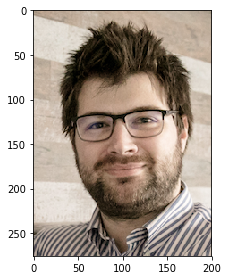

In [3]:
photo = img_as_float(io.imread("assets/chris.png"))
io.imshow(photo)
plt.show()

### Converting the image to black & white

Eventually, we will need to provide a set of point coordinates to the GNG model for training. Therefore, we'll have to generate a binary black-and-white image from the above. We begin by bracketing exposure intensity to omit some of the background and focus on the important details.

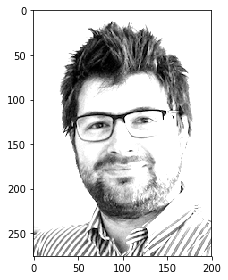

In [4]:
v_min, v_max = np.percentile(photo, (0, 32))
photo = exposure.rescale_intensity(filters.gaussian(color.rgb2gray(photo), 
                                                    sigma=0.2), 
                                   in_range=(v_min, v_max))
io.imshow(photo)
plt.show()

In order to simplify the image, we perform a binary thresholding, where instead of greyscale values, we assign a truth value to each pixel. This is necessary as we will continue to convert each set pixel to a point coordinate value later on, which requires an unambiguous allocation of each pixel as set or unset.

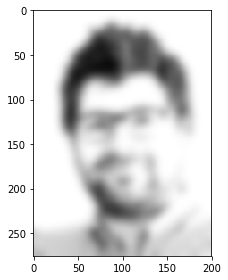

In [5]:
adaptive_threshold = filters.threshold_local(photo, block_size = 31)

io.imshow(adaptive_threshold)
plt.show()

The localized adaptive threshold algorithm (`threshold_local`) creates a map of the image, which we will use for creating the binarised thresholded image.

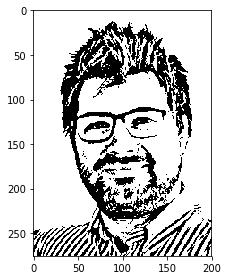

In [6]:
binary_image = photo > adaptive_threshold
io.imshow(binary_image)
plt.show()

### Converting image to data points

In order to be able to run the GNG algorithm, we need to convert the above image into an array of point coordinates.

In [7]:
df = []
for (x, y), val in np.ndenumerate(binary_image):
    if val == False:
        df.append([y, -x])

Number of data points: 14,260


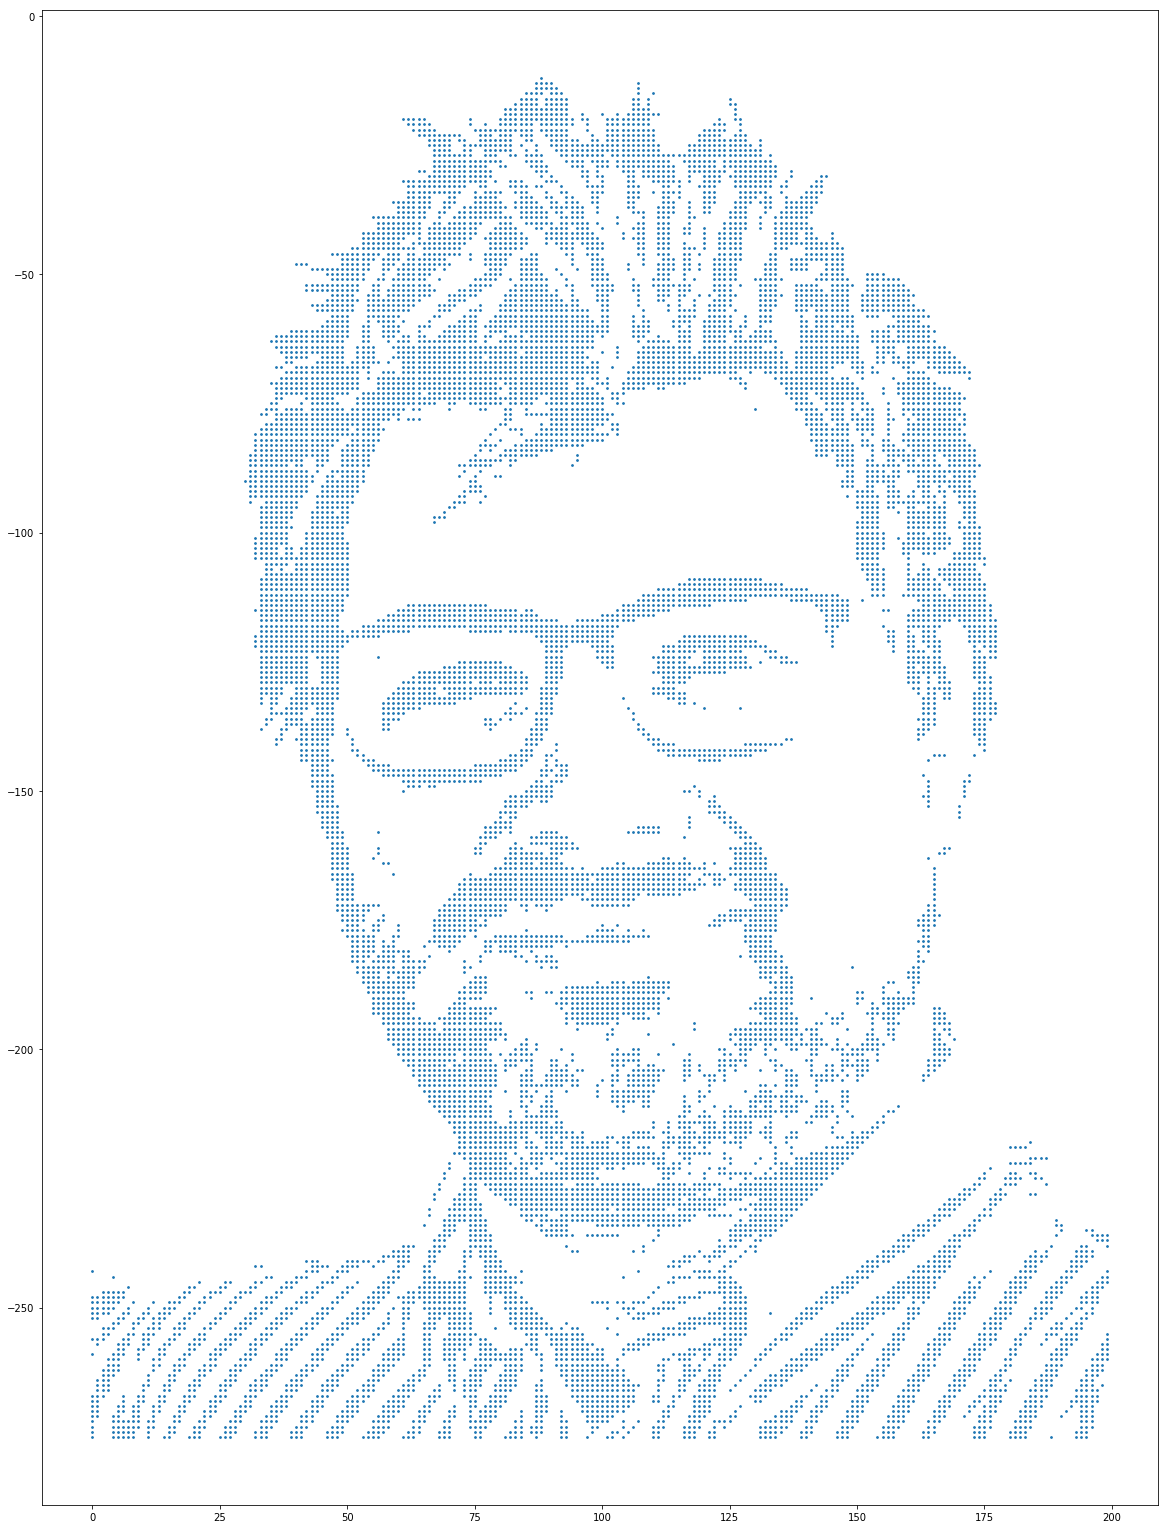

In [8]:
scale_factor = 0.001   
data = scale_factor * np.array(df)
print("Number of data points: {:,}".format(len(data)))

plt.figure(figsize=(20, 27.5))
plt.scatter(*np.array(data).T / scale_factor, s=3, alpha=1)

While not trivial at first sight, these are actually individual data points on a discrete $\mathbb{Z}^{+2}$ grid:

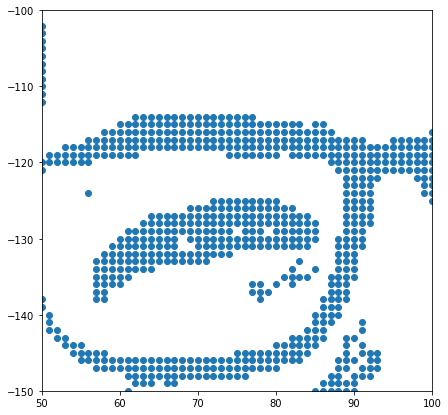

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(*np.array(df).T)
plt.xlim(50, 100)
plt.ylim(-150, -100)
plt.show()

### Setting up the plotting function

The first helper function, `hash_edge`, creates a unique hash of an edge. We'll be using this to determine whether an edge is new or not.

In [10]:
def euclidean_dist(n1w, n2w):
    return math.sqrt((n1w[0][0] - n2w[0][0])**2 + (n1w[0][1] - n2w[0][1])**2)

This helper function will be invoked every iteration to allow us to see how the network is faring thus far.

In [11]:
def plot_img(graph, size_factor=0.2, cmap_padding = 0.3, alpha_padding = 0.8):
    max_p2p_distance = 0
    
    figure_size = np.array([20, 27.5]) * size_factor
    plt.figure(figsize=figure_size)
    
    for n1, n2 in graph.edges:
        weights = np.concatenate([n1.weight, n2.weight])

        dist = euclidean_dist(n1.weight, n2.weight)
        max_p2p_distance = max(dist, max_p2p_distance)

        plt.plot(*weights.T,
                 color = cm.plasma_r(max(cmap_padding, dist/(max_p2p_distance + 1E-10))),
                 alpha = max(alpha_padding, 1-(dist/(max_p2p_distance + 1E-10))),
                 linewidth = 0.5)

    plt.show()

### Setting up the neural network and parametrising it

Now we need to parametrise the GNG algorithm. Because our input data is, in effect, an array of coordinate pairs `[x, y]` describing each a point in $\mathbb{R}^2$ space, the number of inputs (`n_inputs`) is `2`. We are also starting with a low number of nodes `n_start_nodes` (the lowest number of starting nodes, i.e. 2), to allow a slow but visible growth – with a high number of starting nodes, a GNG acts very much like a SOFM and simply begins to approximate the data with preset data points instead of 'growing into' the data set. However, we do configure for quick growth (`n_iter_before_neuron_added`) and quick adaptation (unupdated edges decay after a short time, set by `max_edge_age`).

In [12]:
environment.reproducible()

gng = algorithms.GrowingNeuralGas(n_inputs = 2, 
                                  n_start_nodes = 2, 
                                  shuffle_data = True, 
                                  verbose = True, 
                                  step = 0.3, 
                                  neighbour_step = 0.005, 
                                  max_edge_age = 10, 
                                  max_nodes = 1000, 
                                  n_iter_before_neuron_added = 4, 
                                  after_split_error_decay_rate=0.5,
                                  error_decay_rate=0.995,
                                  min_distance_for_update=0.01)


Main information

[ALGORITHM] GrowingNeuralGas

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] train_end_signal = None
[OPTION] after_split_error_decay_rate = 0.5
[OPTION] error_decay_rate = 0.995
[OPTION] max_edge_age = 10
[OPTION] max_nodes = 1000
[OPTION] min_distance_for_update = 0.01
[OPTION] n_inputs = 2
[OPTION] n_iter_before_neuron_added = 4
[OPTION] n_start_nodes = 2
[OPTION] neighbour_step = 0.005
[OPTION] step = 0.3



With our model initialised, it's time to 'train' it.

epoch #1, train err: 2.794422, time: 12 sec


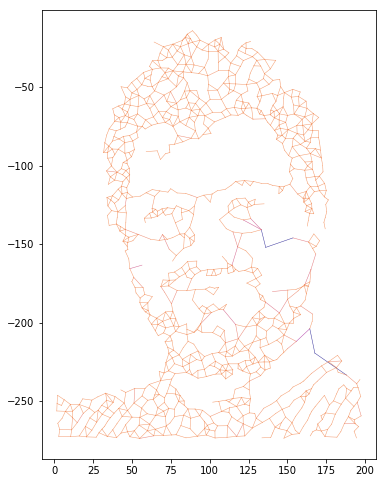

epoch #2, train err: 1.851068, time: 14 sec


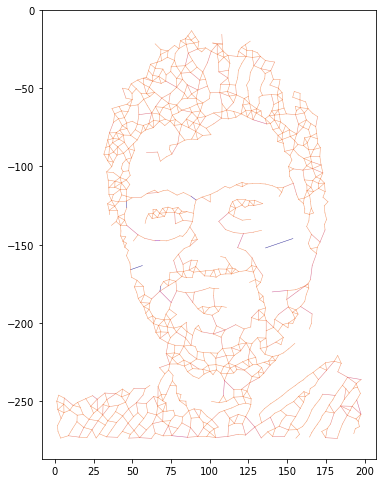

epoch #3, train err: 1.814564, time: 14 sec


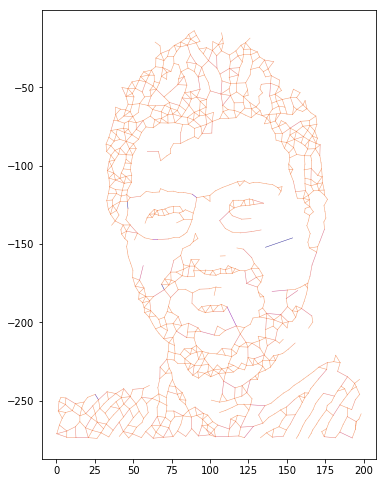

epoch #4, train err: 1.804680, time: 15 sec


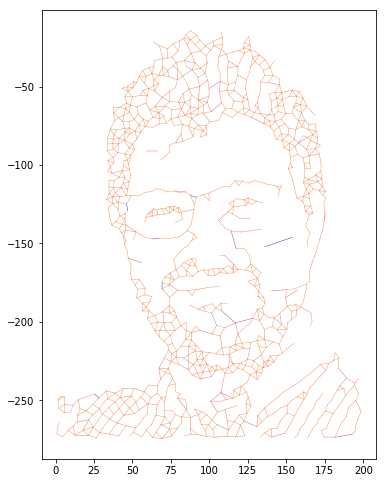

epoch #5, train err: 1.804893, time: 14 sec


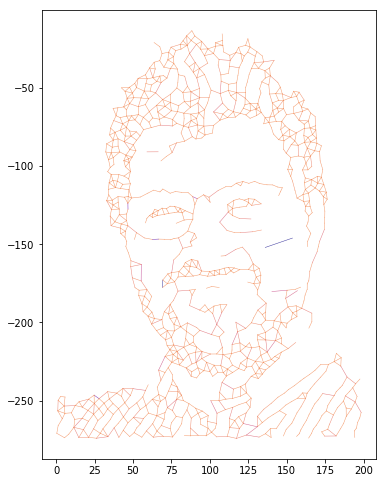

epoch #6, train err: 1.803813, time: 14 sec


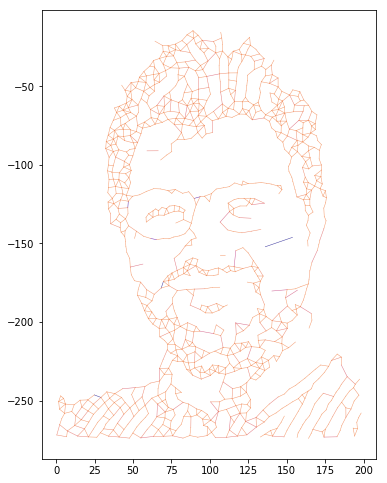

epoch #7, train err: 1.788860, time: 15 sec


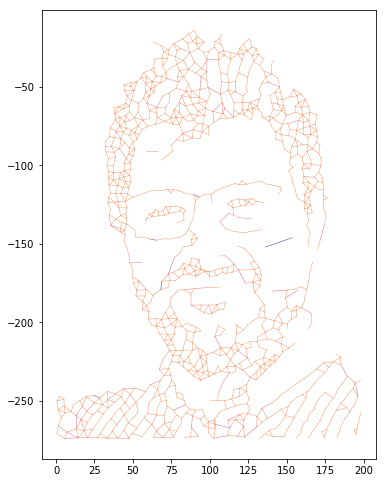

epoch #8, train err: 1.790499, time: 14 sec


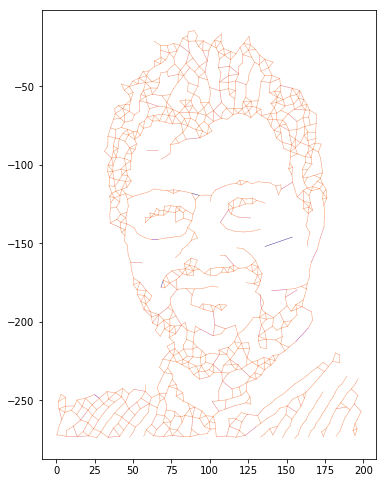

epoch #9, train err: 1.792446, time: 15 sec


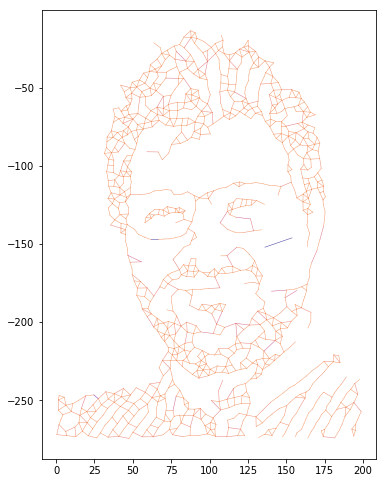

epoch #10, train err: 1.788723, time: 14 sec


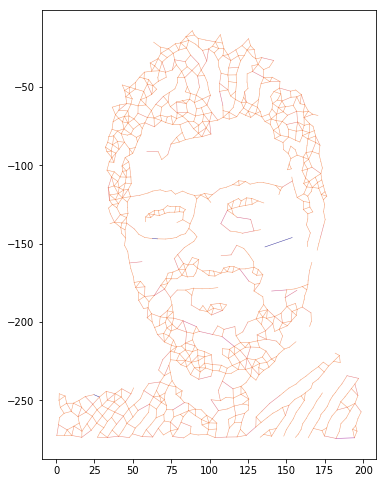

In [13]:
for i in tqdm(range(10)):
    gng.train(df, summary = 'inline', epochs = 1)
    plot_img(gng.graph, 0.3)
    previous_graph = gng.graph

### Animating a lower-resolution image

Rendering the above images takes up to ten seconds per frame on a relatively fast (AWS `c5.xlarge`) computer. Therefore, creating a long convergent animation will require us to slightly downsample our image. The following will create a much longer animation from lower-density data, but with the same method.

In [17]:
environment.reproducible()

gng = algorithms.GrowingNeuralGas(n_inputs = 2, 
                                  n_start_nodes = 2, 
                                  shuffle_data = True, 
                                  verbose = False, 
                                  step = 0.2, 
                                  neighbour_step = 0.005, 
                                  max_edge_age = 20, 
                                  max_nodes = 1000, 
                                  n_iter_before_neuron_added = 10, 
                                  after_split_error_decay_rate=0.5,
                                  error_decay_rate=0.995,
                                  min_distance_for_update=0.02)

In the following, we'll be using rotating data subsampling to gradually train the GNG, accelerating the generation of the map. We're also reducing the training rate (# of iterations before new neurons are added, provided to `gng` as the `n_iter_before_neuron_added` parameter) over time to slow down training and increase number of samples.

(warning: running this function is bound to take an enormously long time, up to several hundred hours on a high-power cloud instance.)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=29.97, metadata=dict(artist='Kristof Csefalvay'))

fig = plt.figure(figsize = (5, 6.875))
plt.xticks([], [])
plt.yticks([], [])

def animate(i):
    for line in animate.prev_lines:
        line.remove()
            
    max_p2p_distance = 0
    max_err = 0
    
    n = int(0.5 * gng.n_iter_before_neuron_added * (1 + i // 100))

    sampled_data_ids = np.random.choice(len(data), n)
    sampled_data = data[sampled_data_ids, :]
    gng.train(sampled_data, epochs=1)

    lines = []
    
    for n1, n2 in gng.graph.edges:
        weights = np.concatenate([n1.weight, n2.weight])

        dist = euclidean_dist(n1.weight, n2.weight)
        max_p2p_distance = max(dist, max_p2p_distance)

        line, = plt.plot(*weights.T,
                        color = cm.plasma_r(max(0.2, dist/(max_p2p_distance + 0.0000001))),
                        alpha = max(0.8, 1-(dist/(max_p2p_distance + 0.0000001))),
                        linewidth = 1.0)

        lines.append(line)
        
        lines.append(plt.scatter(*weights.T, 
                                 color = cm.plasma_r(dist/(max_p2p_distance + 0.0000001)), 
                                 s = 2,
                                 alpha = 0.6))
    animate.prev_lines = lines
    return lines

animate.prev_lines = []
anim = animation.FuncAnimation(fig, animate, tqdm(np.arange(1000)), interval=33, blit=True, save_count=9999)
anim.save("face_build.mp4", writer=writer)
HTML(anim.to_html5_video())

The result is shown below:

In [5]:
%%HTML
<video width="300" height="411" controls>
  <source src="face_build.mp4" type="video/mp4">
</video>

Note how, with the progression of time, the distance of points is equalized (colours correspond to edge length) as the relatively longest edges are incrementally split up into smaller ones.